In [1]:
from transformers import AutoTokenizer, pipeline, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer

import numpy as np
import pandas as pd
import datasets
import pyarrow as pa
from datasets import load_metric

In [2]:
df = pd.read_json("../app_reviews/reviews.json")

<AxesSubplot:>

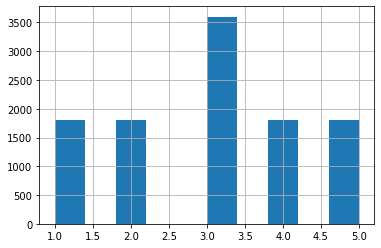

In [3]:
df["score"].hist()

In [4]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [5]:
class_names = ['negative', 'neutral', 'positive']

array([[<AxesSubplot:title={'center':'sentiment'}>]], dtype=object)

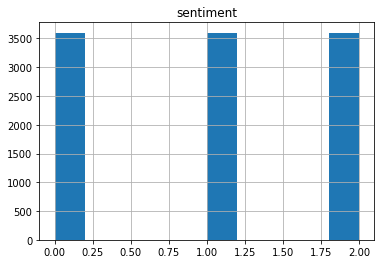

In [6]:
df.hist("sentiment")

In [7]:
model_checkpoint = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [8]:
def build_dataset(label_df, test_percentage=0.2):
    new_df = pd.DataFrame()
    new_df["label"] = label_df["sentiment"]
    new_df["text"] = label_df["content"]
    df_a = pa.Table.from_pandas(new_df, preserve_index=False)
    dataset = datasets.Dataset(df_a)
    split_dataset = dataset.train_test_split(test_percentage)
    return split_dataset

In [9]:
dataset = build_dataset(df.sample(n=2000))

In [10]:
# Prepare the text inputs for the model
def preprocess_function(ex):
    return tokenizer(ex["text"], truncation=True)

tokenized_train = dataset["train"].map(preprocess_function, batched=True)
tokenized_test = dataset["test"].map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]


In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
labels = ["negative", "neutral", "positive"]
id2label = {i: label for i, label in enumerate(labels)}
label2id = {v: k for k, v in id2label.items()}

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, id2label = id2label, label2id=label2id)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [14]:

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [15]:
repo_name = "model_v0"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch", 
)

In [16]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
/home/buga/.virtualenvs/chico/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1600
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 200


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 50%|█████     | 100/200 [10:46<10:37,  6.38s/it]Saving model checkpoint to model_v0/checkpoint-100
Configuration saved in model_v0/checkpoint-100/config.json
Model weights saved in model_v0/checkpoint-100/pytorch_model.bin
tokenizer config file saved in model_v0/checkpoint-100/tokenizer_config.json
Special tokens file saved in model_v0/checkpoint-100/special_tokens_map.json
100%|██████████| 200/200 [21:34<00:00,  5.75s/it]Saving model checkpoint to model_v0/checkpoint-200
Configuration saved in model_v0/checkpoint-200/config.json
Model weights saved in model_v0/checkpoint-200/pytorch_model.bin
tokenizer config file saved in model_v0/checkpoint-200/tokenizer_config.json
Special tokens file saved in model_v0/checkpoint-200/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 200/200 [21:36<00:00,  6.48s/it]

{'train_runtime': 1297.289, 'train_samples_per_second': 2.467, 'train_steps_per_second': 0.154, 'train_loss': 0.8475044250488282, 'epoch': 2.0}


TrainOutput(global_step=200, training_loss=0.8475044250488282, metrics={'train_runtime': 1297.289, 'train_samples_per_second': 2.467, 'train_steps_per_second': 0.154, 'train_loss': 0.8475044250488282, 'epoch': 2.0})

In [18]:
trainer.save_model(repo_name)

Saving model checkpoint to model_v0
Configuration saved in model_v0/config.json
Model weights saved in model_v0/pytorch_model.bin
tokenizer config file saved in model_v0/tokenizer_config.json
Special tokens file saved in model_v0/special_tokens_map.json


In [21]:
trained_model = pipeline("sentiment-analysis", model="model_v0", tokenizer=tokenizer)

loading configuration file model_v0/config.json
Model config BertConfig {
  "_name_or_path": "model_v0",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tor

In [32]:
trained_model("Pq ifood é tão caro meu deus")

[{'label': 'negative', 'score': 0.4328788220882416}]

In [33]:
trained_model("@ravlls Quero é tudo do ifood")

[{'label': 'positive', 'score': 0.7255421280860901}]

In [35]:
trained_model("Pedi batata no ifood por 1 real para jantar. Te amo @iFood")

[{'label': 'positive', 'score': 0.8365402221679688}]

In [37]:
trained_model("Essa nova interface do IFood tá horrível")

[{'label': 'negative', 'score': 0.6841387748718262}]

In [38]:
trained_model("Disse pra minha namorada que tava triste e não queria fazer janta, ela mandou eu pedir ifood e meu deu o cartão")

[{'label': 'neutral', 'score': 0.5542026162147522}]